
# PyPSA-Eur Power Model Validation Notebook for Ember Project

This notebook aims to check and validate outputs from the **PyPSA-Eur power model** for the **Ember project**, focusing on the following countries:

- Germany (DE)  
- Netherlands (NL)  
- Italy (IT)  
- Poland (PL)  
- Czech Republic (CZ)  
- Greece (GR)

The notebook performs validation for the following:

- Power flows (compared to ENTSO-E data)  
- Generation dispatch  
- Installed capacity per country  
- Energy demand per country  
- Geographic plots of installed capacities  

---

### Steps to Run This Notebook

#### Step 1: Fork the Ember-Flexibility-Study Repository

Visit the GitHub repository and fork it to your account:  
🔗 https://github.com/open-energy-transition/Ember-Flexibility-Study

---

#### Step 2: Clone the Repository Locally

Clone the forked repository to your local machine using the following command in your terminal:

```bash
git clone https://github.com/open-energy-transition/Ember-Flexibility-Study
```

This will download the repository into your preferred directory.

---

#### Step 3: Copy the `config.yaml` File

Ensure that the `config.yaml` file (which contains model configurations needed to generate results) is copied into the `config/` folder of the repository.

---

#### Step 4: Activate the PyPSA-Eur Conda Environment

If you're using Conda, activate the PyPSA-Eur environment with the following command in your terminal:

```bash
conda activate pypsa-eur
```

Make sure you have the environment installed. If not, follow instructions in the PyPSA-Eur documentation to set it up.

---

#### Step 5: Run the Electricity Model Using Gurobi

If you have Gurobi installed and a valid license, run the electricity model using the following command in your terminal:

```bash
snakemake --scheduler-ilp-solver GUROBI_CMD --cores 1 -call solve_elec_networks
```

This command will run the model and generate a solved network file (in `.nc` format) under the `results/network/` folder.

---

#### Step 6: Load the Network in Your Notebook

After running the model, open the validation notebook in your preferred Jupyter environment. Load the network by adding and running the appropriate code to read the generated `.nc` file in a notebook cell.

---

#### Step 7: Run All Notebook Cells

Once the network is loaded, execute all the cells in the notebook to perform the following tasks:

- Visualize power flows between countries  
- Check generation dispatch per country  
- Validate installed capacities  
- Compare energy demand per country  
- Plot installed capacities on maps


## Preparation

### Import Packages

In [1]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx


# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

# change current directory to parent folder
import os
import sys



# plotting settings
max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

## Loading the solved network

In [2]:
n=pypsa.Network("C:\\Users\\user\\Desktop\\Ember-Flexibility-Study\\results\\base_s_39_elec_lv1.0.nc")

INFO:pypsa.io:Imported network base_s_39_elec_lv1.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


## Country-Level Dispatch and Capacity Analysis

This section defines a function `plot_dispatch_and_capacity_per_country(n, time="2013-10-09")` that visualizes two key aspects of the power system model for the six focus countries (DE, NL, IT, PL, CZ, GR):

1. **Hourly Power Dispatch**:  
   - Plotted in a 3x2 grid (one subplot per country)
   - Shows generation per carrier, storage dispatch, net imports, and load profiles
   - Helps validate model behavior and generation mix at a specific hour or date

2. **Total Installed Capacity per Carrier and Country**:  
   - Presented as a separate stacked bar chart
   - Displays total installed capacity (in GW) by generation/storage technology and country

---

### What the Code Does – Step-by-Step Explanation

#### Input Validation
- Checks that the input `n` is a valid PyPSA network object.
- Confirms required time series attributes (`generators_t`, `storage_units_t`, etc.) are available.

#### Country Loop
Iterates over the six selected countries:
- Filters generators and storage units connected to each country’s buses.
- Aggregates installed capacity per carrier.
- For the selected `time`, retrieves:
  - **Generator dispatch** (in GW)
  - **Storage dispatch** (if available)
  - **Net imports** (power flowing into the country)
  - **Load profile** (consumer demand)

#### Dispatch Plot
- Generates area plots per country:
  - Positive values: Generation and imports
  - Negative values: Charging (for storage)
  - Load profile overlaid as a black line
- Enhances readability with spacing, consistent coloring (based on carrier color), and labeled legends.

#### Capacity Plot
- Builds a separate bar chart summarizing installed capacity per country and carrier.
- Filters out carriers with zero capacity.
- Uses consistent coloring with dispatch plots for easier comparison.

#### Outputs
- Saves two images:
  - `dispatch_per_country.png`
  - `capacity_per_country.png`
- These can be used for inclusion in validation reports or presentations.

---

### Example Code Block to Run

```python
# Load the solved network before calling this
n = pypsa.Network("results/network/<your_network_file>.nc")
plot_dispatch_and_capacity_per_country(n, time="2013-10-09")


C:\Users\user\AppData\Local\Temp\ipykernel_28472\984154544.py:63: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gens_t = n.generators_t.p.loc[time][gens.index].groupby(gens.carrier, axis=1).sum().div(1e3)  # GW
C:\Users\user\AppData\Local\Temp\ipykernel_28472\984154544.py:63: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gens_t = n.generators_t.p.loc[time][gens.index].groupby(gens.carrier, axis=1).sum().div(1e3)  # GW
C:\Users\user\AppData\Local\Temp\ipykernel_28472\984154544.py:63: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gens_t = n.generators_t.p.loc[time][gens.index].groupby(gens.carrier, axis=1).sum().div(1e3)  # GW
C:\Users\user\AppData\Local\Temp\ipykernel_28472\984154544.py:63: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
 

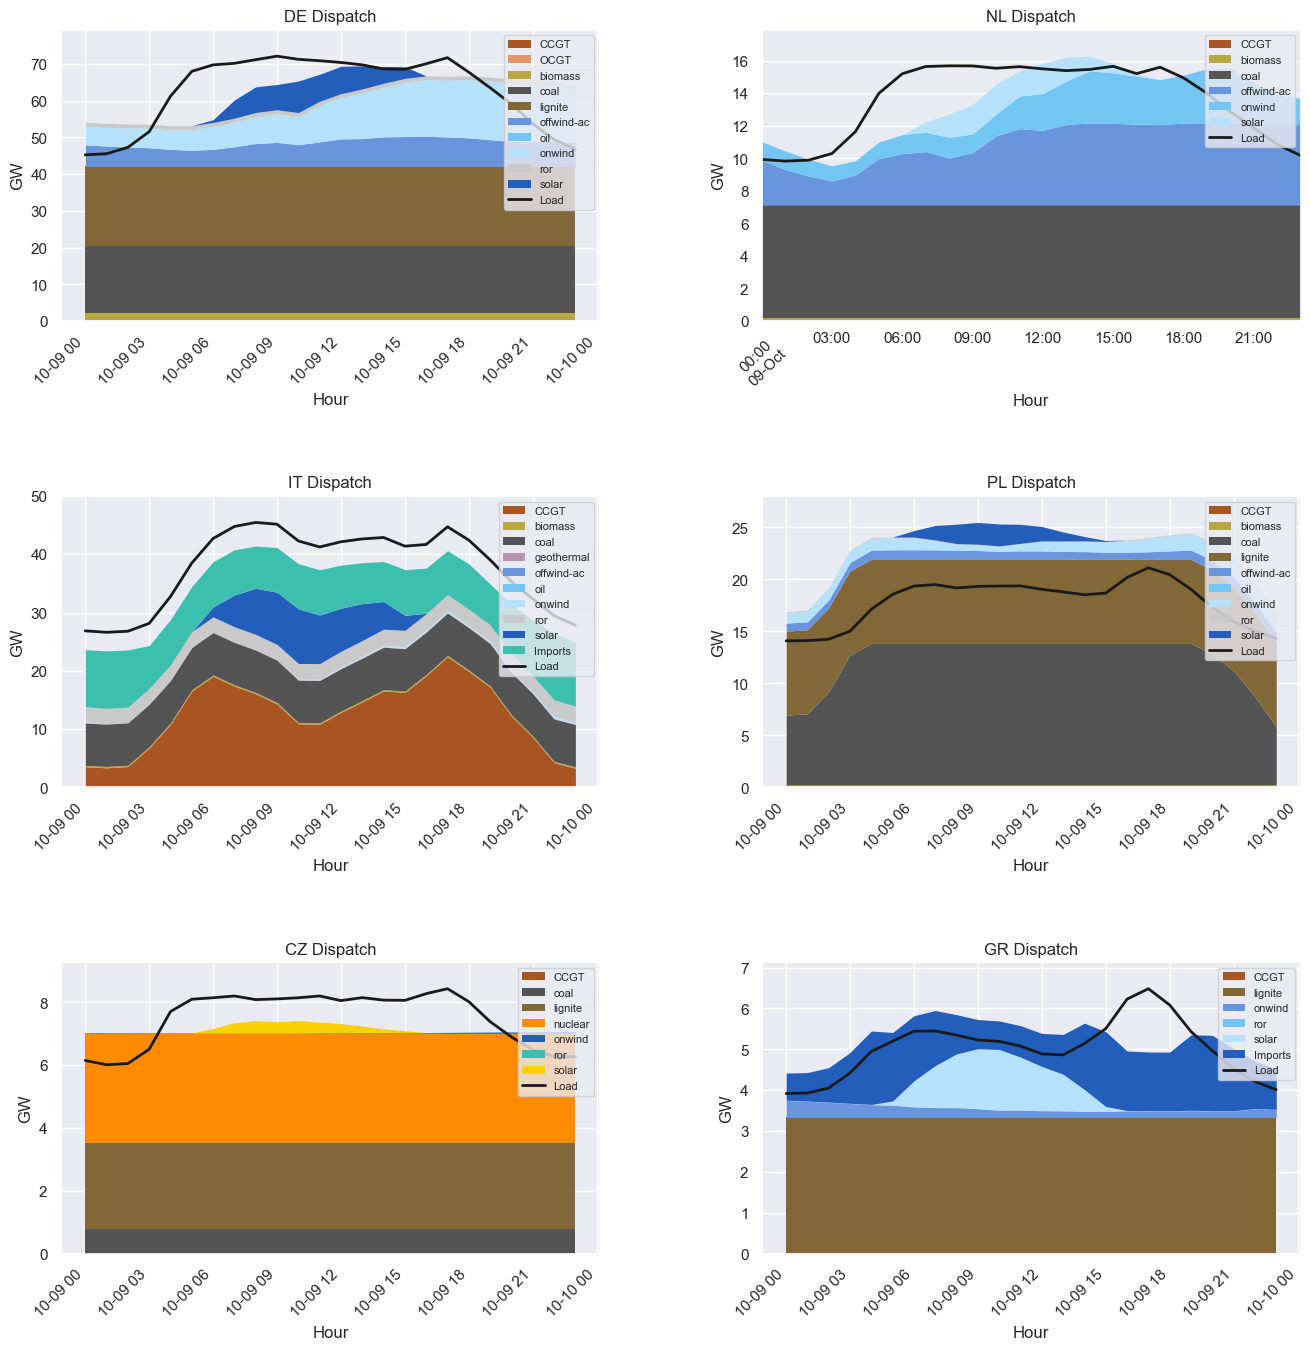

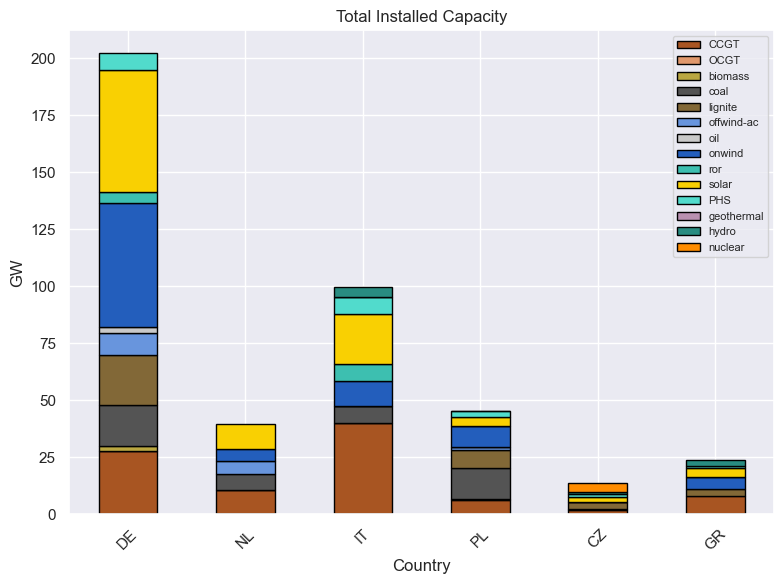

In [3]:
def plot_dispatch_and_capacity_per_country(n, time="2013-10-09"):
    """
    Plot dispatch (generation, storage, imports, and load) for focus countries in a 3x2 grid
    with increased row spacing, larger subplots, and visible load profiles, and total installed
    capacity in a separate figure.
    
    Parameters:
    - n: PyPSA network object
    - time: Date string (e.g., "2013-10-09") for dispatch plot
    """
    # Input validation
    if not isinstance(n, pypsa.Network):
        raise TypeError("Input 'n' must be a PyPSA Network object.")
    if not all(hasattr(n, attr) for attr in ['generators_t', 'storage_units_t', 'loads_t', 'lines_t']):
        raise ValueError("Network missing required attributes: generators_t, storage_units_t, loads_t, or lines_t")
    
    # Define focus countries
    focus_countries = ['DE', 'NL', 'IT', 'PL', 'CZ', 'GR']
    
    # Function to get country code from bus
    def get_country(bus):
        return bus[:2] if isinstance(bus, str) and len(bus) >= 2 else None
    
    # Function to calculate net imports (from power_flow_analysis_with_comparison.py)
    def get_net_import(n, country, snapshots):
        net_import = pd.Series(0.0, index=snapshots)
        for line in n.lines.index:
            bus0_country = get_country(n.lines.loc[line, 'bus0'])
            bus1_country = get_country(n.lines.loc[line, 'bus1'])
            if bus0_country == country and bus1_country != country:
                net_import += n.lines_t.p0[line]  # Positive flow from bus0 to bus1 (export)
            elif bus1_country == country and bus0_country != country:
                net_import += -n.lines_t.p0[line]  # Negative flow to bus1 (import)
        return -net_import  # Invert to get imports (positive) and exports (negative)
    
    # --- Dispatch Figure ---
    # Create figure with 3x2 grid for dispatch plots, increased spacing and size
    fig_dispatch, axes_dispatch = plt.subplots(
        3, 2, figsize=(16, 18), gridspec_kw={'wspace': 0.3, 'hspace': 0.6}
    )
    dispatch_axes = axes_dispatch.flatten()  # Flatten to iterate over all 6 subplots
    
    # Dictionary to store capacity data
    capacity_data = {country: {} for country in focus_countries}
    
    # Plot dispatch for each focus country
    for idx, country in enumerate(focus_countries):
        ax = dispatch_axes[idx]
        
        # Filter generators and storage units for the country
        gens = n.generators[n.generators.bus.map(get_country) == country]
        p_by_carrier = gens.groupby('carrier').p_nom.sum().div(1e3)  # Installed capacity in GW
        for carrier in p_by_carrier.index:
            capacity_data[country][carrier] = capacity_data[country].get(carrier, 0) + p_by_carrier[carrier]
        
        if not n.storage_units.empty:
            storages = n.storage_units[n.storage_units.bus.map(get_country) == country]
            sto_p_nom = storages.groupby('carrier').p_nom.sum().div(1e3)  # Installed capacity in GW
            for carrier in sto_p_nom.index:
                capacity_data[country][carrier] = capacity_data[country].get(carrier, 0) + sto_p_nom[carrier]
        
        # Get dispatch data (absolute values)
        gens_t = n.generators_t.p.loc[time][gens.index].groupby(gens.carrier, axis=1).sum().div(1e3)  # GW
        gens_t = np.abs(gens_t)  # Use absolute values
        p_by_carrier = gens_t
        
        if not n.storage_units.empty and not storages.empty:
            sto_t = n.storage_units_t.p.loc[time][storages.index].groupby(storages.carrier).sum().div(1e3)  # GW
            sto_t = np.abs(sto_t)  # Use absolute values
            p_by_carrier = pd.concat([p_by_carrier, sto_t], axis=1)
        
        # Get net imports for the country
        snapshots = n.snapshots[n.snapshots.slice_indexer(time, time)]
        net_imports = get_net_import(n, country, snapshots).div(1e3)  # GW
        if not net_imports.empty:
            p_by_carrier['Imports'] = net_imports
        
        # Handle colors, assigning gray for undefined carriers and green for imports
        default_color = 'gray'
        color_map = n.carriers.color.fillna(default_color).to_dict()
        color_map['Imports'] = 'green'  # Green for imports
        color = p_by_carrier.columns.map(lambda x: color_map.get(x, default_color))
        
        # Filter out columns with all zero or NaN
        p_by_carrier = p_by_carrier.loc[:, p_by_carrier.sum() > 0]
        if p_by_carrier.empty:
            ax.text(0.5, 0.5, 'No Dispatch Data', ha='center', va='center')
            ax.set_title(f'{country} Dispatch')
            ax.set_ylabel('GW')
            ax.set_xlabel('Hour')
            continue
        
        # Plot positive dispatch (generation and imports)
        p_by_carrier.where(p_by_carrier > 0).plot.area(
            ax=ax,
            linewidth=0,
            color=color,
        )
        
        # Plot negative dispatch (charging, if any)
        charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1)
        if not charge.empty:
            charge_color = charge.columns.map(lambda x: color_map.get(x, default_color))
            charge.plot.area(
                ax=ax,
                linewidth=0,
                color=charge_color,
            )
        
        # Plot load
        loads = n.loads[n.loads.bus.map(get_country) == country]
        if loads.empty:
            print(f"No loads found for {country}. Available buses: {n.loads.bus.unique()}")
            ax.text(0.5, 0.4, 'No Load Data', ha='center', va='center', fontsize=8)
        else:
            load_data = n.loads_t.p_set.loc[time][loads.index].sum(axis=1).div(1e3)  # GW
            if load_data.empty or load_data.sum() == 0:
                print(f"Empty or zero load data for {country}. Load indices: {loads.index}")
                ax.text(0.5, 0.4, 'No Load Data', ha='center', va='center', fontsize=8)
            else:
                load_data.plot(ax=ax, c="k", label='Load', linewidth=2)
        
        # Adjust y-axis to ensure load is visible
        max_load = load_data.max() if not load_data.empty else 0
        max_dispatch = p_by_carrier.where(p_by_carrier > 0).sum(axis=1).max() if not p_by_carrier.empty else 0
        max_y = max(max_load, max_dispatch) * 1.1  # 10% buffer
        ax.set_ylim(0, max_y if max_y > 0 else 1)  # Avoid zero limit
        
        ax.set_title(f'{country} Dispatch')
        ax.set_ylabel('GW')
        ax.set_xlabel('Hour')
        ax.legend(loc='upper right', fontsize=8)
        ax.tick_params(axis='x', rotation=45)
    
    # Save dispatch figure
    plt.tight_layout()
    plt.savefig('dispatch_per_country.png', bbox_inches='tight')
    plt.show()
    
    # --- Capacity Figure ---
    # Create separate figure for total installed capacity
    fig_capacity, capacity_ax = plt.subplots(figsize=(8, 6))
    
    # Plot total installed capacity
    capacity_df = pd.DataFrame(capacity_data).fillna(0)
    capacity_df = capacity_df.loc[capacity_df.sum(axis=1) > 0]
    if not capacity_df.empty:
        color = capacity_df.index.map(lambda x: n.carriers.color.get(x, default_color))
        capacity_df.T.plot.bar(
            ax=capacity_ax,
            stacked=True,
            color=color,
            edgecolor='black'
        )
        capacity_ax.set_title('Total Installed Capacity')
        capacity_ax.set_ylabel('GW')
        capacity_ax.set_xlabel('Country')
        capacity_ax.legend(loc='upper right', fontsize=8)
        capacity_ax.tick_params(axis='x', rotation=45)
    else:
        capacity_ax.text(0.5, 0.5, 'No Capacity Data', ha='center', va='center')
        capacity_ax.set_title('Total Installed Capacity')
        capacity_ax.set_ylabel('GW')
        capacity_ax.set_xlabel('Country')
    
    # Save capacity figure
    plt.tight_layout()
    plt.savefig('capacity_per_country.png', bbox_inches='tight')
    plt.show()

# Example usage:
# n = pypsa.Network("path/to/pypsa-eur-network.nc")
plot_dispatch_and_capacity_per_country(n, time="2013-10-09")

## Total Annual Electricity Demand by Country

This section defines a function `plot_total_demand_per_country(n)` that calculates and visualizes the **total annual electricity demand** for each of the six focus countries. The output is presented in **terawatt-hours (TWh)** and displayed as a bar chart.

---

### What the Code Does – Step-by-Step Explanation

#### Input
- `n`: A PyPSA `Network` object containing time series data for electricity loads across all buses.

#### Focus Countries
- The function focuses on:
  - Germany (DE)
  - Netherlands (NL)
  - Italy (IT)
  - Poland (PL)
  - Czech Republic (CZ)
  - Greece (GR)

#### Demand Calculation Steps

1. **Extract Loads for Each Country**:
   - For each country, buses are filtered based on their 2-letter prefix (e.g., `"DE"`).
   - Loads connected to these buses are selected.

2. **Sum Time Series Data**:
   - For each load in the selected country, the hourly demand (in MWh) is summed across the entire year.
   - The result is total electricity demand in **TWh** (`1 TWh = 1,000,000 MWh`).

3. **Handle Missing or Zero Data**:
   - If no load data is found or it's all zero, the function logs a message and sets the demand to 0 for that country.

4. **Create a Bar Chart**:
   - A single bar is plotted per country.
   - The bars show the total annual demand in TWh.
   - Each bar is labeled with the numeric value (e.g., 350.2 TWh).

---

### Output
- A saved figure: `total_demand_per_country.png`
- A bar chart comparing **total annual demand** per country.

---

### Example Usage

```python
# Load the solved network first
n = pypsa.Network("results/network/elec_s_2024.nc")
plot_total_demand_per_country(n)


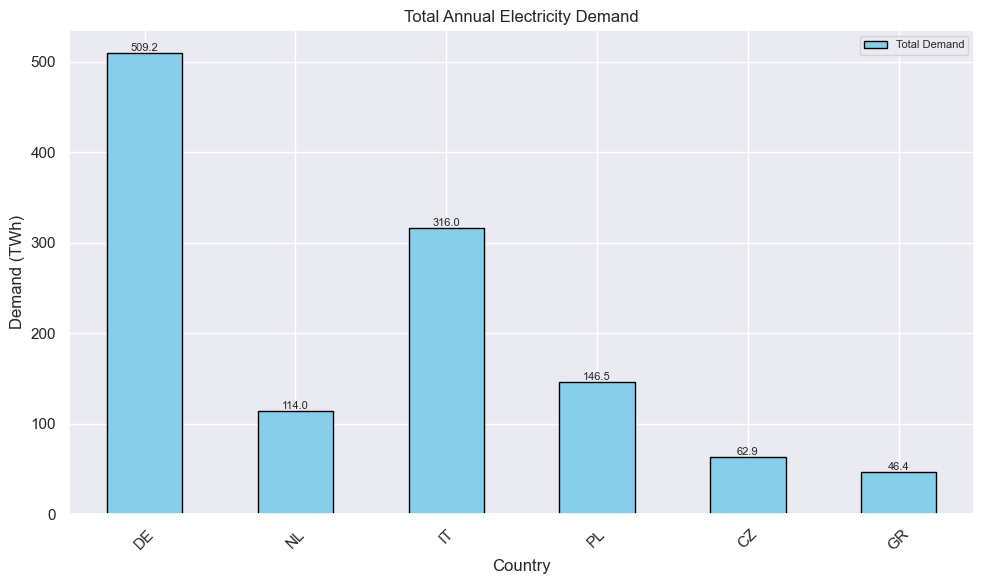

In [4]:
def plot_total_demand_per_country(n):
    """
    Plot total annual electricity demand (2024) in TWh for focus countries.
    
    Parameters:
    - n: PyPSA network object
    """
    # Define focus countries
    focus_countries = ['DE', 'NL', 'IT', 'PL', 'CZ', 'GR']
    
    # Function to get country code from bus
    def get_country(bus):
        return bus[:2] if isinstance(bus, str) and len(bus) >= 2 else None
    
    # Initialize dictionary to store demand data
    demand_data = {country: {} for country in focus_countries}
    
    # Aggregate demand by country
    for country in focus_countries:
        # Filter loads for the country
        loads = n.loads[n.loads.bus.map(get_country) == country]
        if loads.empty:
            print(f"No loads found for {country}. Available buses: {n.loads.bus.unique()}")
            demand_data[country]['Total'] = 0
            continue
        
        # Sum hourly demand (MWh) over the year for each load
        load_demand = n.loads_t.p_set[loads.index].sum()  # MWh
        if load_demand.empty or load_demand.sum() == 0:
            print(f"Empty or zero load data for {country}. Load indices: {loads.index}")
            demand_data[country]['Total'] = 0
            continue
        
        # Convert to TWh (1 TWh = 1e6 MWh) and sum for the country
        total_demand_twh = load_demand.sum() / 1e6  # TWh
        demand_data[country]['Total'] = total_demand_twh
    
    # Create DataFrame from demand data
    demand_df = pd.DataFrame(demand_data).fillna(0)
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    demand_df.T.plot.bar(
        ax=ax,
        stacked=True,
        color='skyblue',  # Single color for total demand (no carrier types)
        edgecolor='black'
    )
    
    ax.set_title('Total Annual Electricity Demand')
    ax.set_ylabel('Demand (TWh)')
    ax.set_xlabel('Country')
    ax.legend(['Total Demand'], loc='upper right', fontsize=8)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on top of bars
    for i, country in enumerate(demand_df.columns):
        total = demand_df[country].sum()
        if total > 0:
            ax.text(i, total, f'{total:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('total_demand_per_country.png', bbox_inches='tight')
    plt.show()


plot_total_demand_per_country(n)


## Power Flow Comparison: PyPSA-Eur vs ENTSO-E 2024

To compare physical power flows from the **PyPSA-Eur model** with the official **ENTSO-E 2024 dataset**, we start by setting a consistent visual style using Matplotlib’s `ggplot` theme. This ensures that all plots are visually coherent and maintain a clean appearance throughout the analysis.

We define a list of transmission line connections, where each line connects two countries via specific buses in the PyPSA-Eur model. Using this, a dictionary (`connection_map`) is constructed to map each line ID to a country-pair format (e.g., `DE-PL`). This facilitates easy identification of cross-border connections in both modeled and observed datasets.

The ENTSO-E 2024 dataset is loaded and filtered to retain only monthly values. We narrow the scope to flows involving our focus countries: **Germany (DE), Netherlands (NL), Italy (IT), Poland (PL), Czech Republic (CZ), and Greece (GR)**. For each month and country pair, we compute the average of the **absolute power flows**, capturing the magnitude of exchange regardless of direction.

From the PyPSA-Eur side, all line power flows (`lines_t.p0`) are reshaped into long format and mapped to country-pair connections using the earlier dictionary. The full time-series dataset is exported to Excel for future reference.

We identify and extract power flows for all transmission lines connected to the focus countries. These lines are validated against the time-series dataset, and their hourly flow data is saved separately. To provide more granularity, we extract and store power flow data for each individual focus country, capturing the behavior of all interconnections involving that country.

To align the resolution of PyPSA-Eur outputs with the ENTSO-E data, the absolute hourly power flows are aggregated into **monthly averages** per connection. This allows for a **direct comparison** between modeled and observed data.

The datasets from ENTSO-E and PyPSA-Eur are then merged on `Connection` and `Month`, and the difference in average flows is calculated. For each connection, a comparison plot is generated showing the monthly average absolute power flows from both sources, allowing for visual inspection of consistency and deviations.

For insight into **intra-day variation**, a snapshot of absolute power flows for a single day (e.g., `2013-01-03`) is plotted. This highlights the daily operational dynamics across the focus interconnectors. If data for the selected date is missing, the first 24 time steps of the model are used as a fallback.

To provide an overall summary, we compute the **annual average absolute power flow** for each focus line and visualize these in a bar chart. This identifies the most active interconnections in the modeled European network.

Lastly, we calculate the **net export** for each focus country by summing all directional flows through cross-border lines. Exports and imports are treated with opposite signs, and the resulting time series is saved to Excel. The average net export (in MW) is printed per country, revealing its typical import/export role in the system.


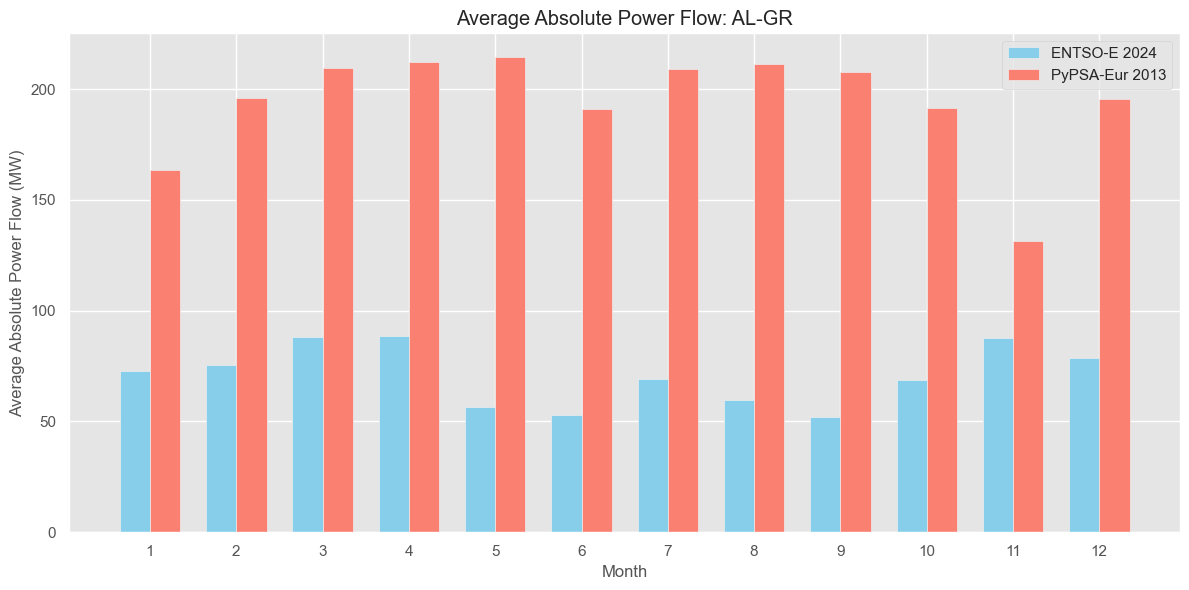

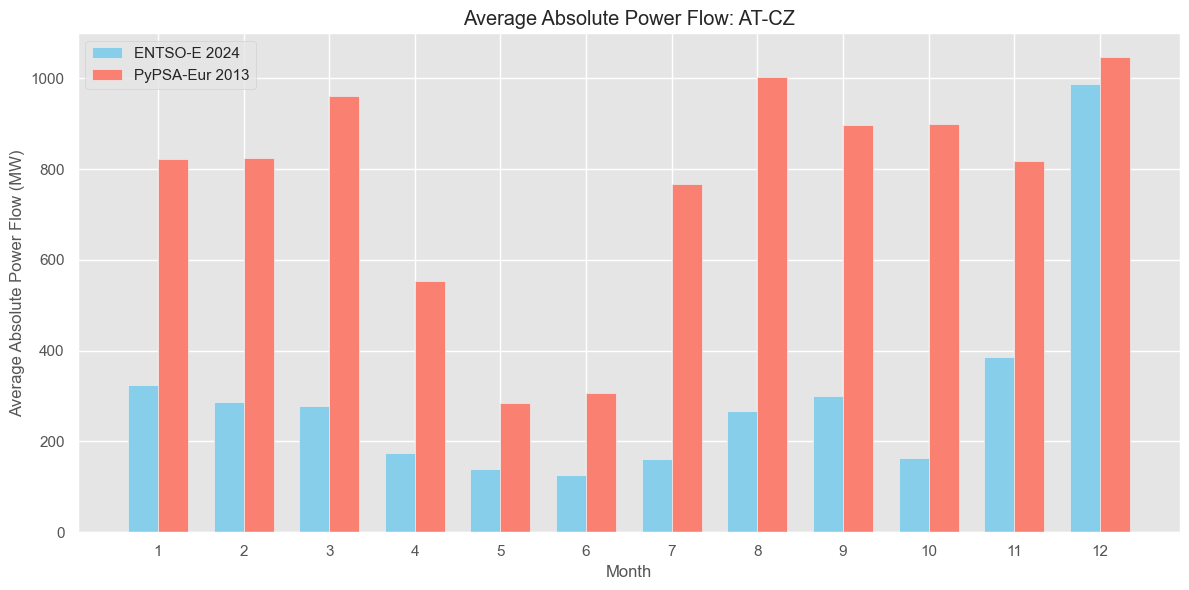

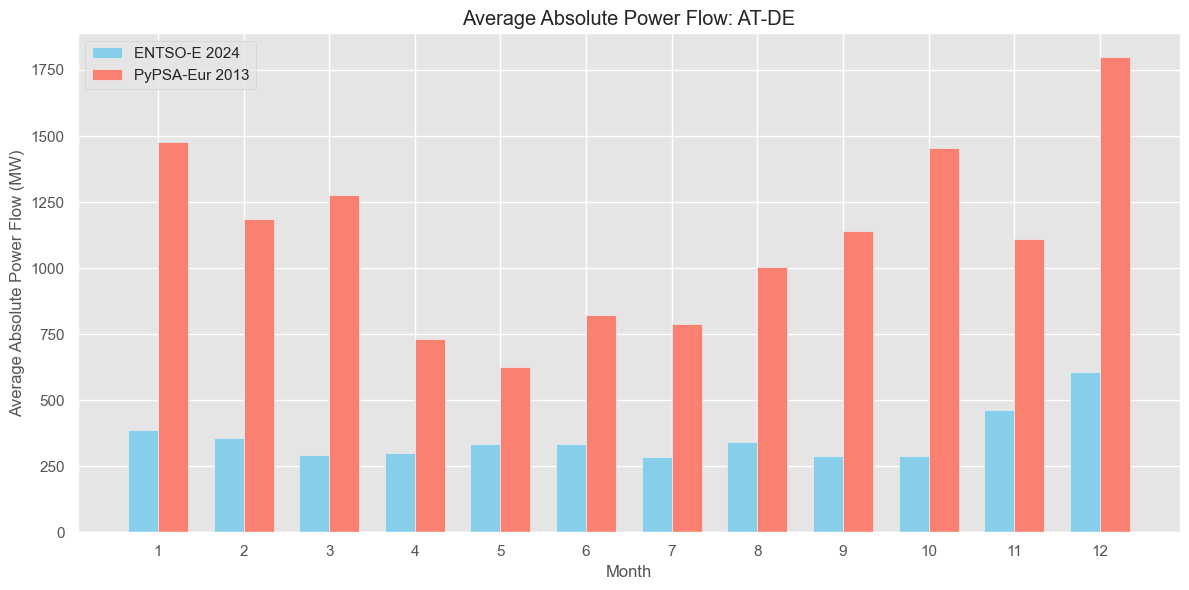

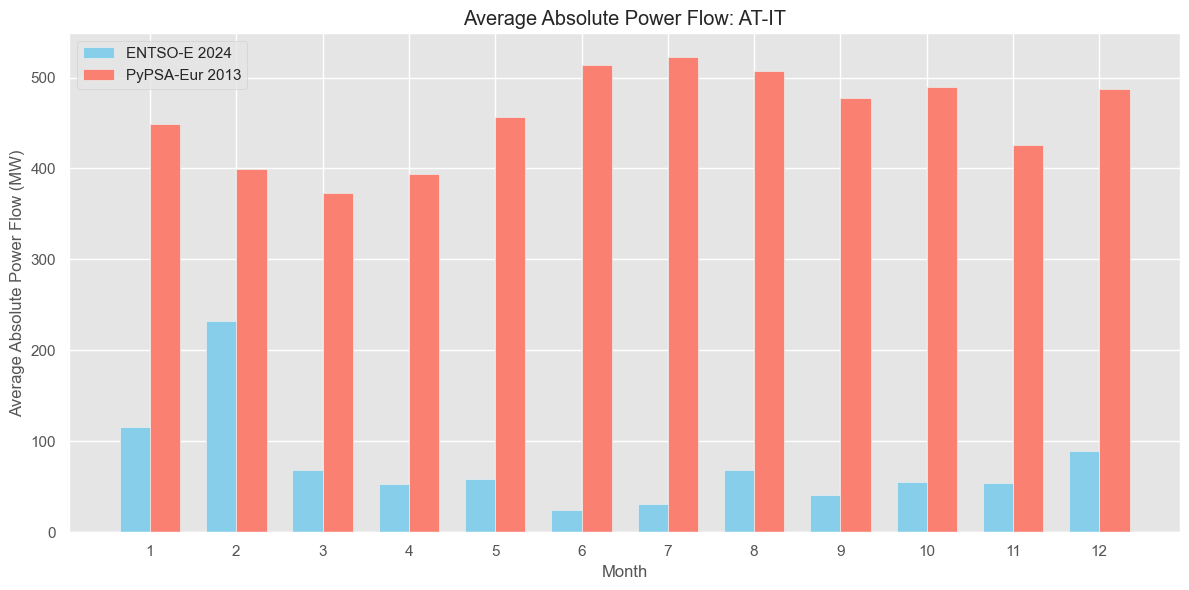

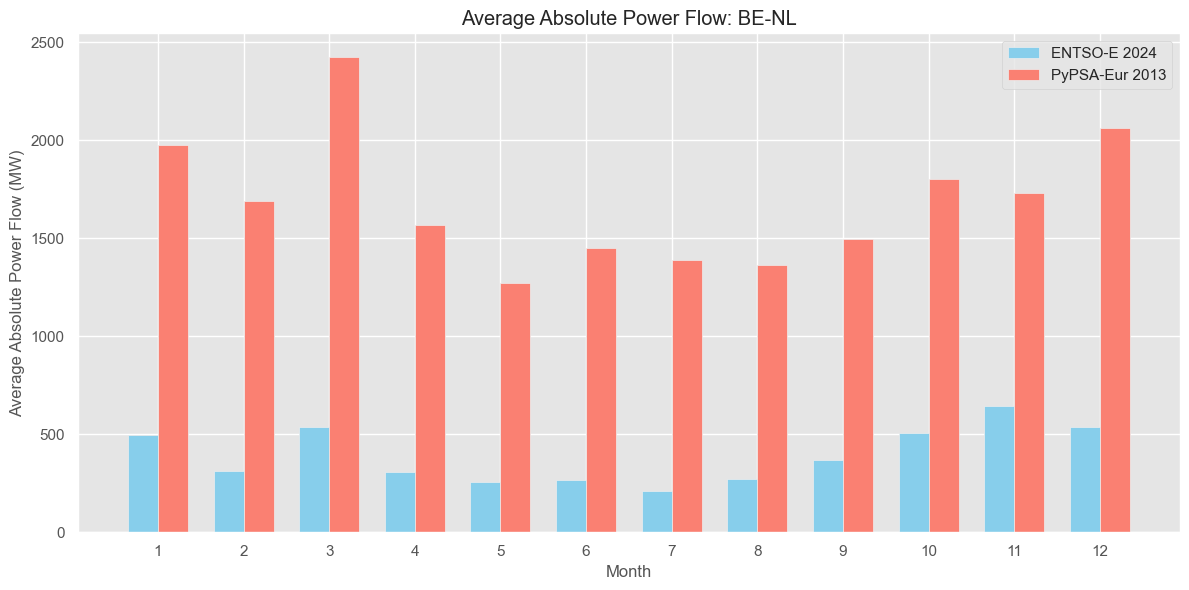

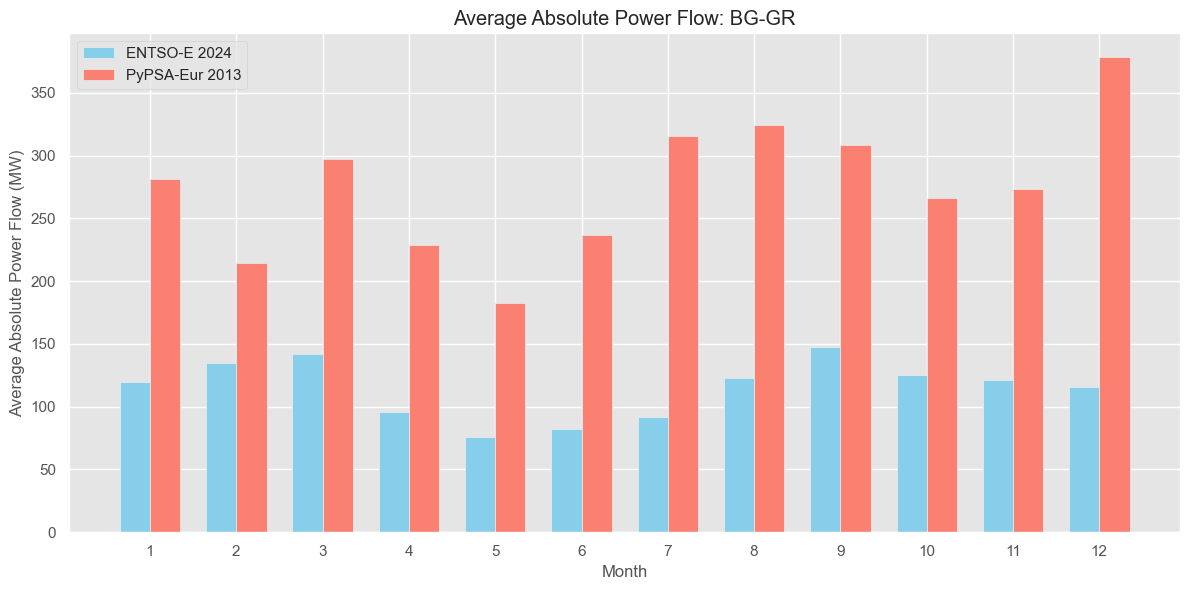

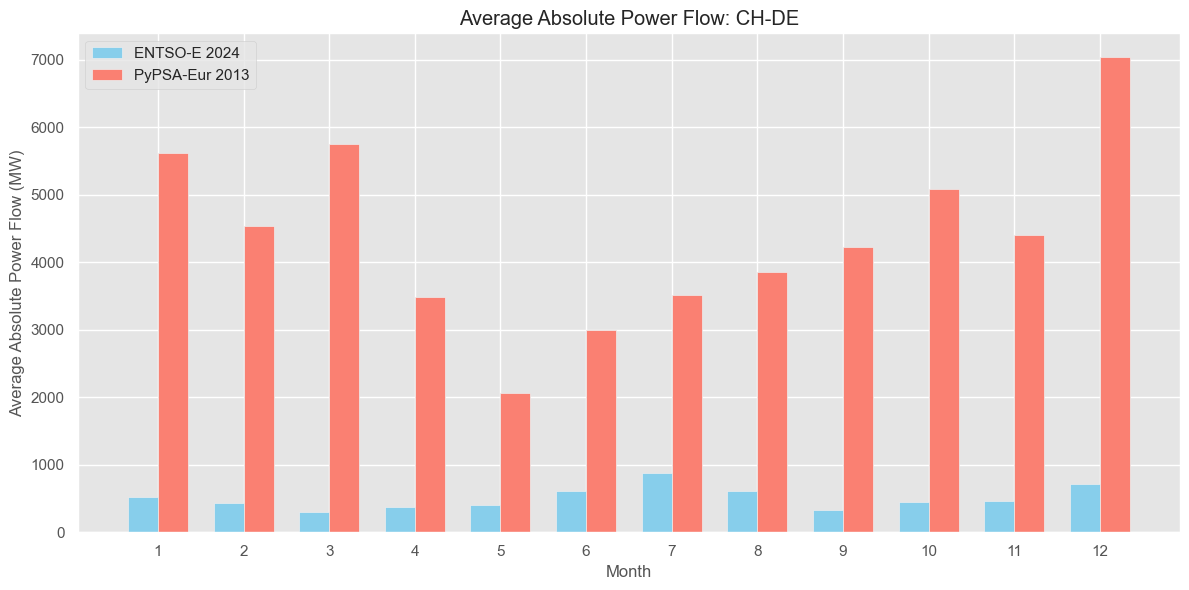

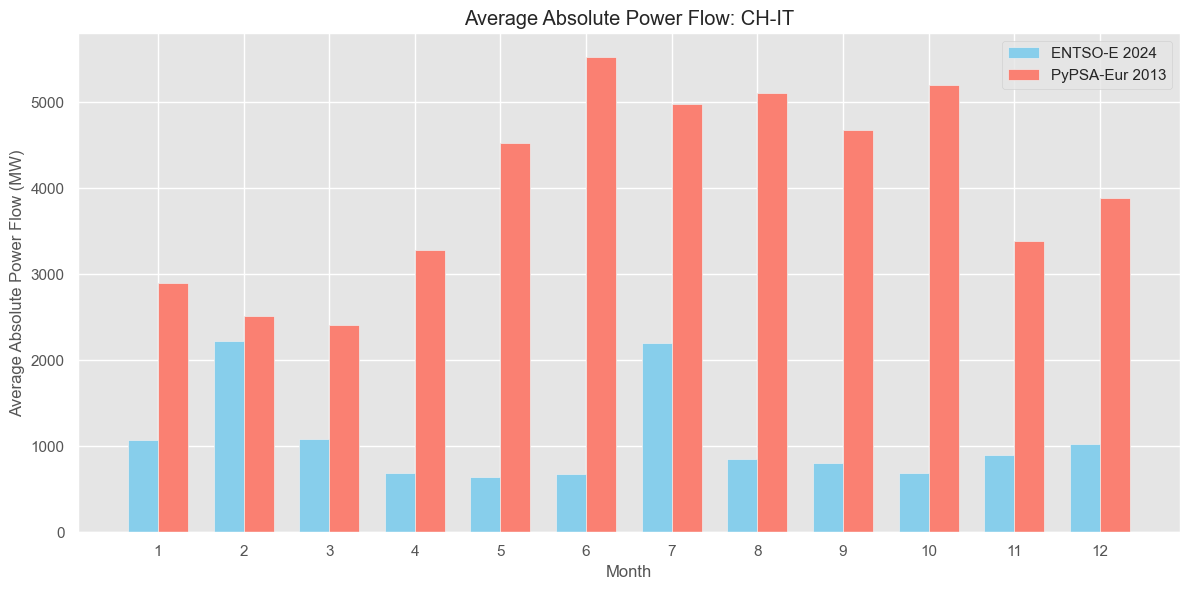

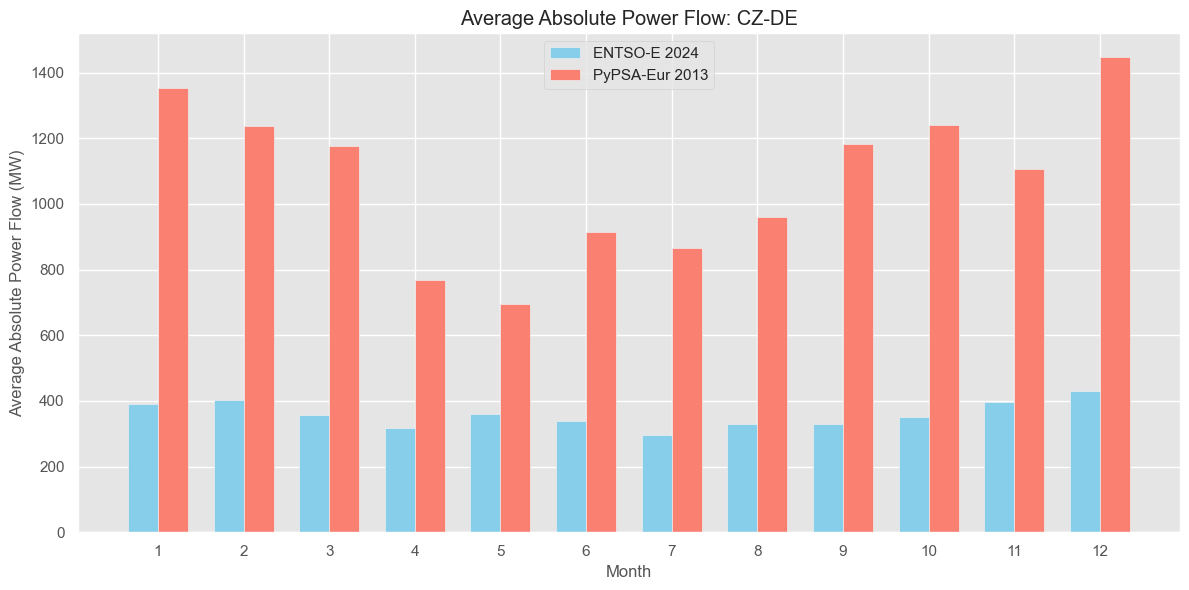

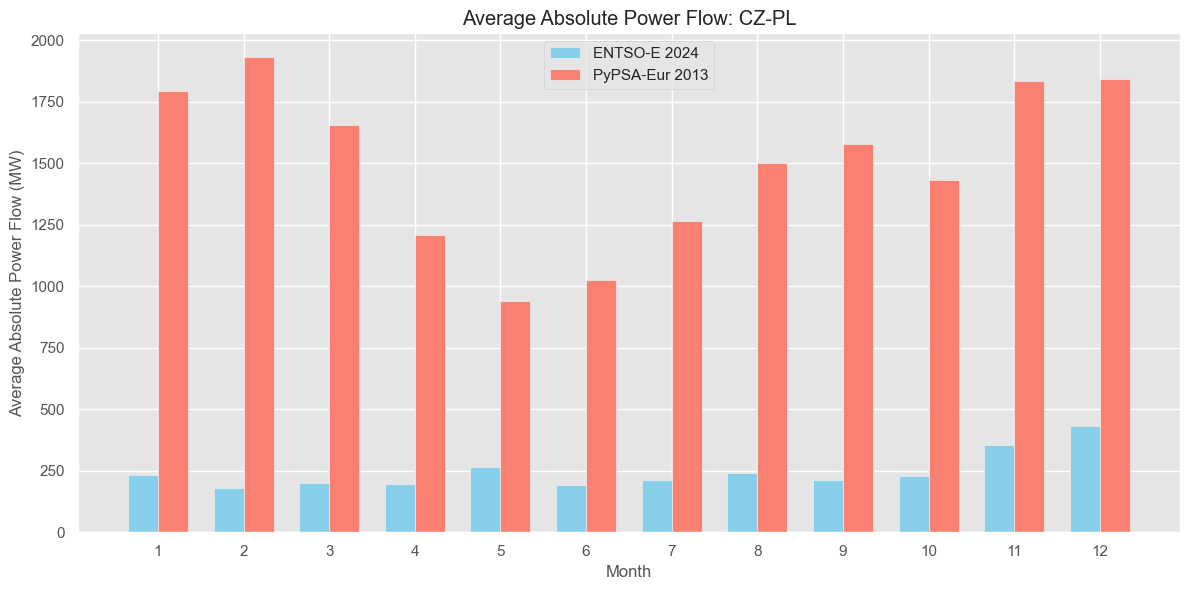

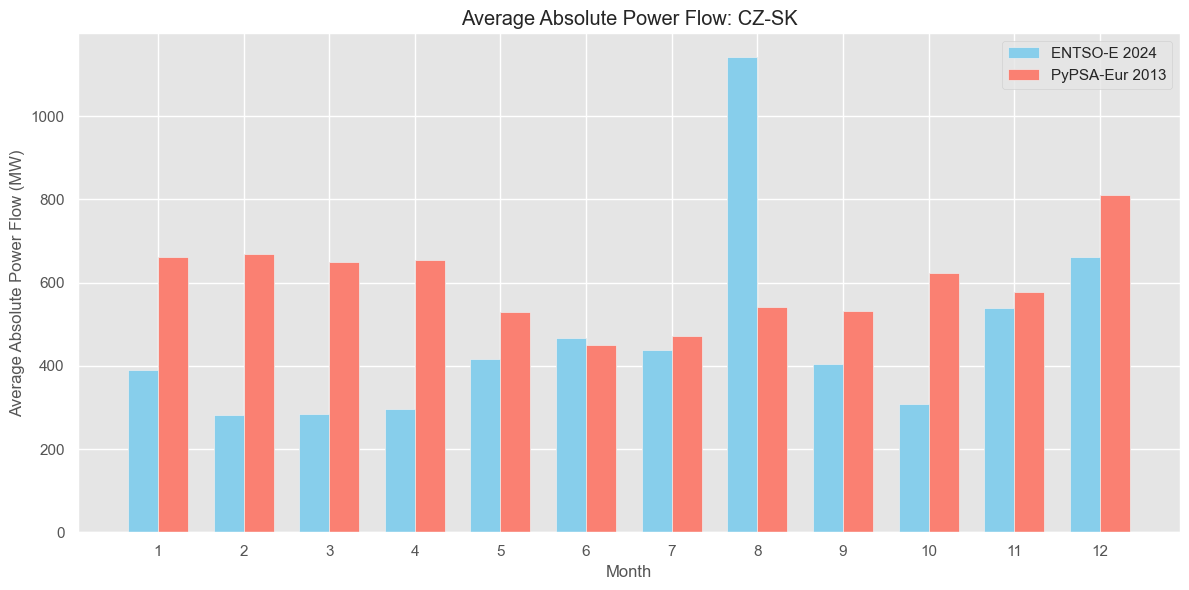

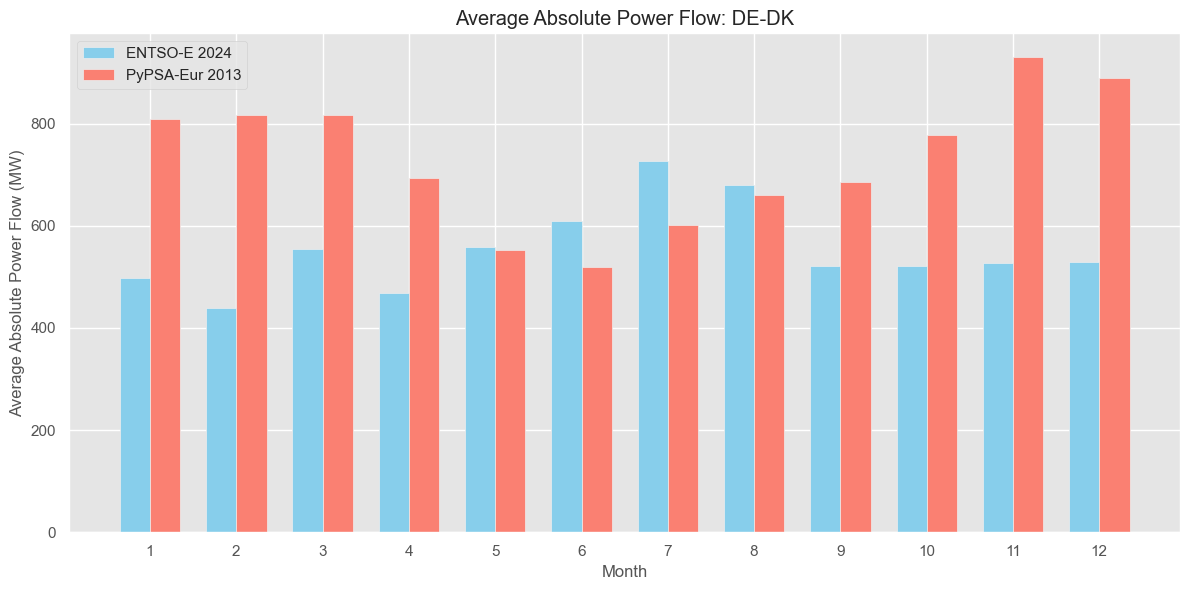

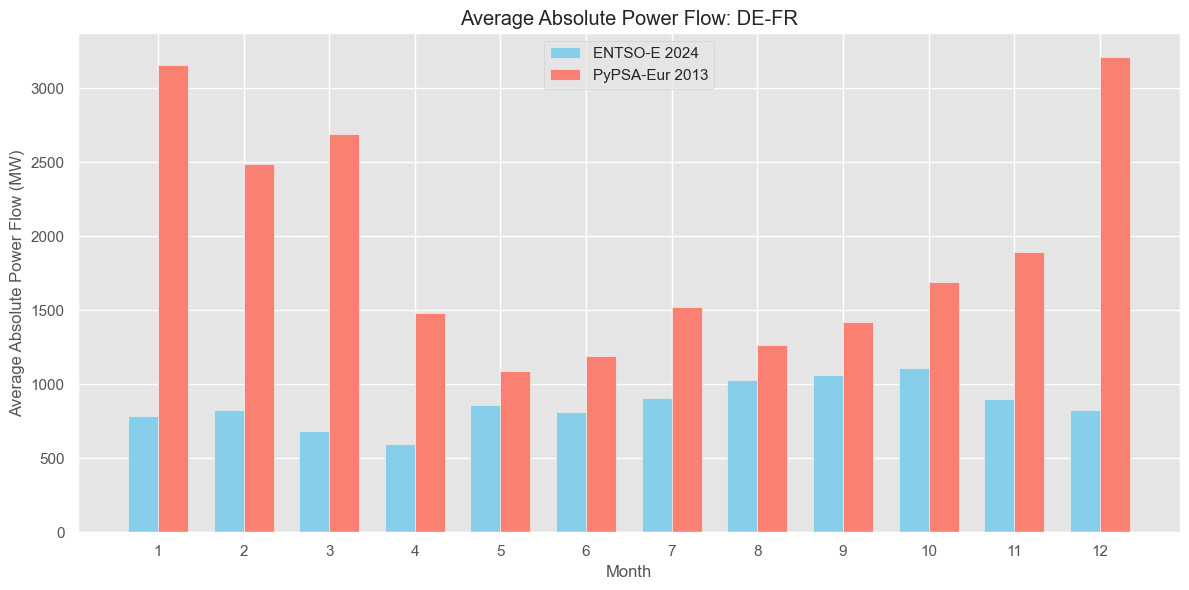

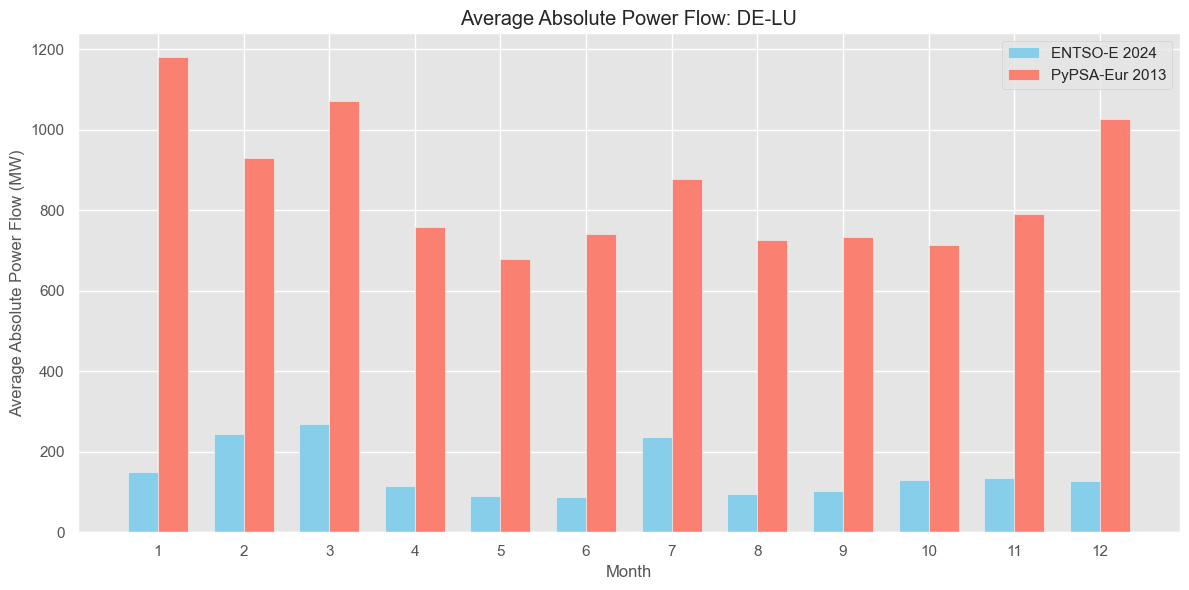

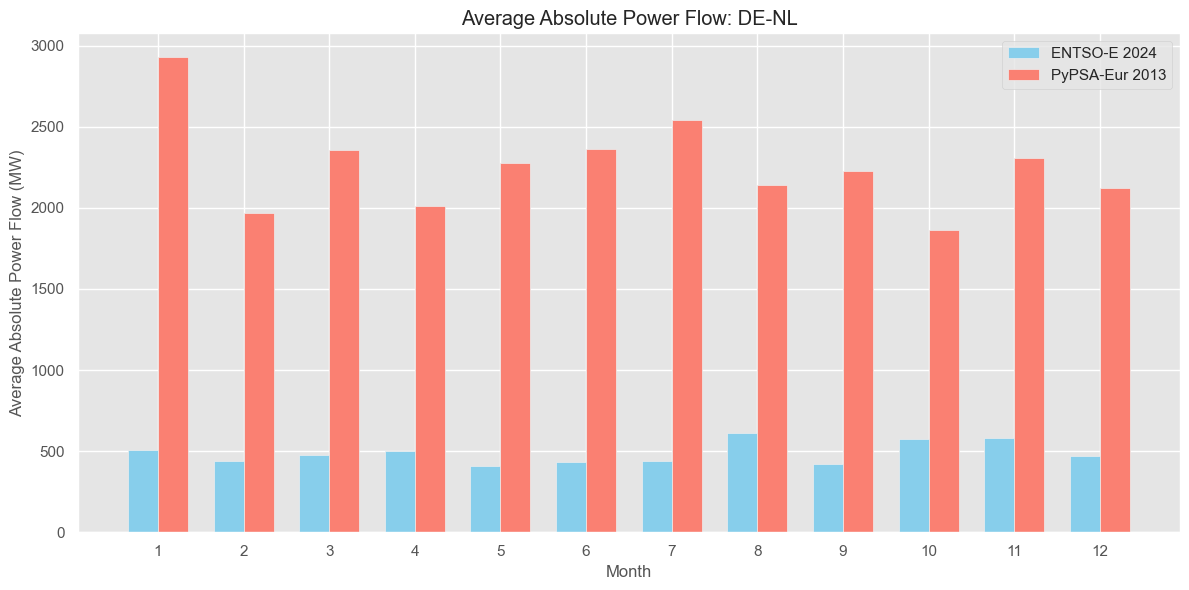

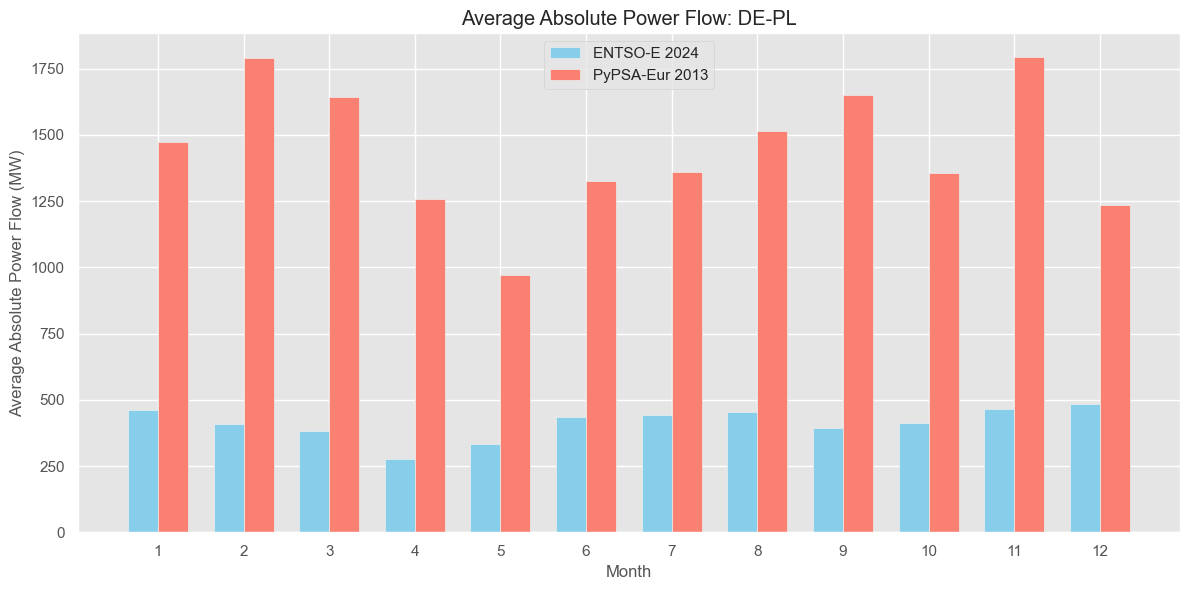

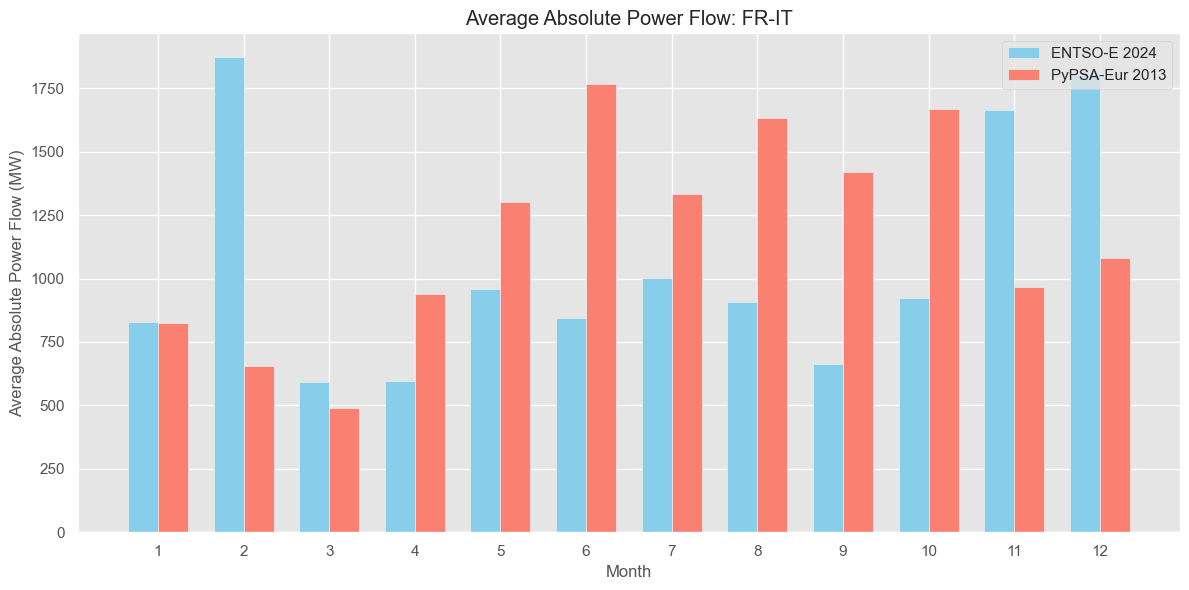

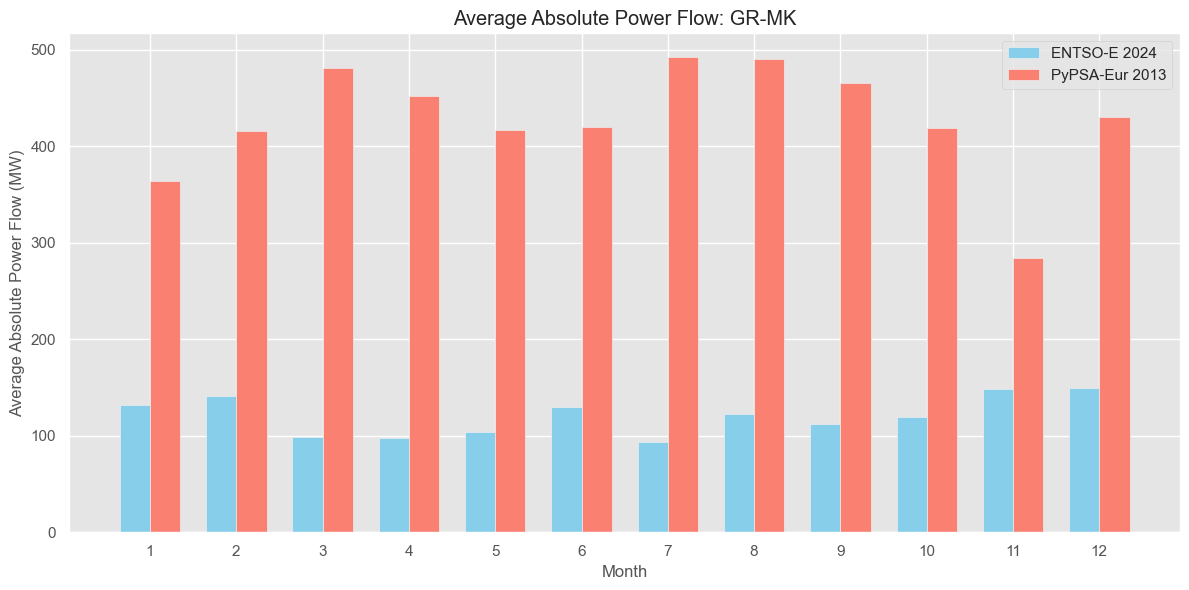

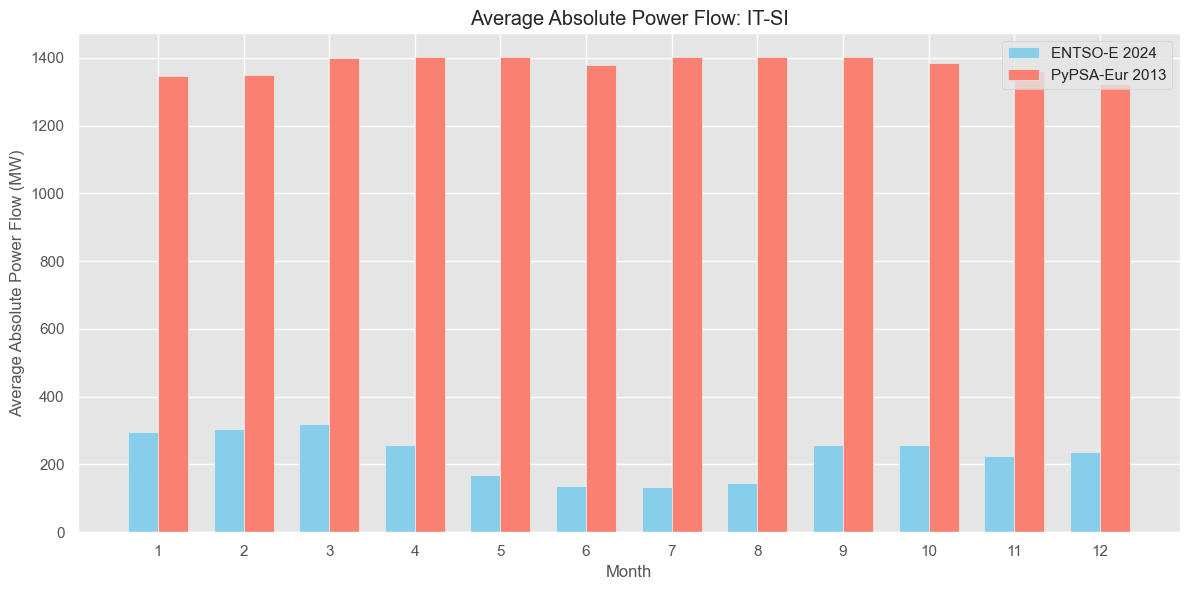

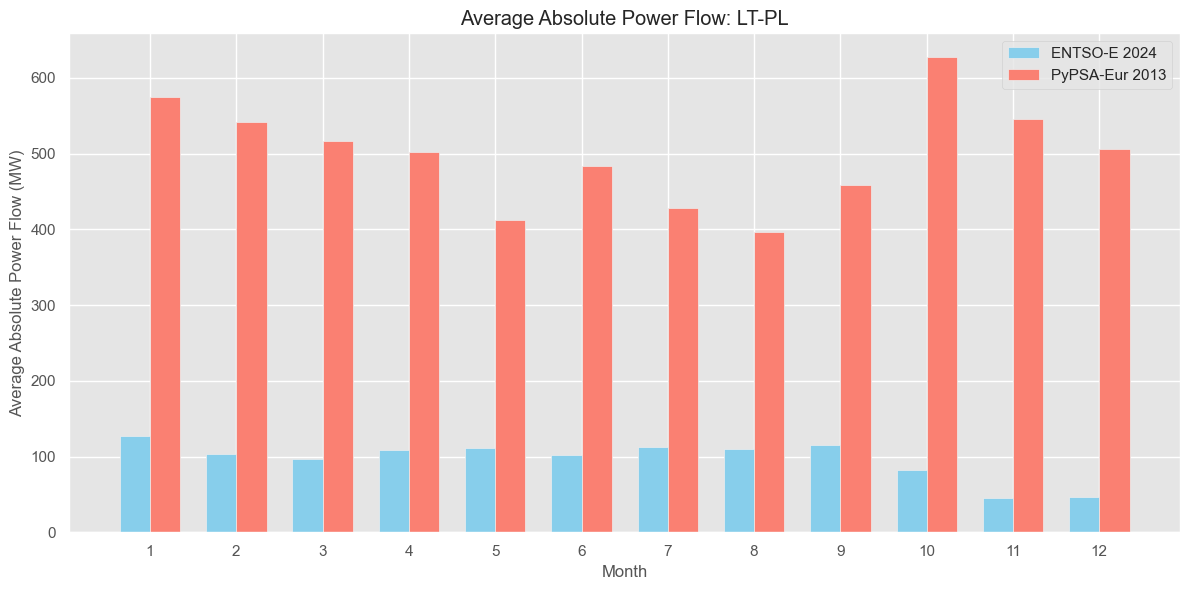

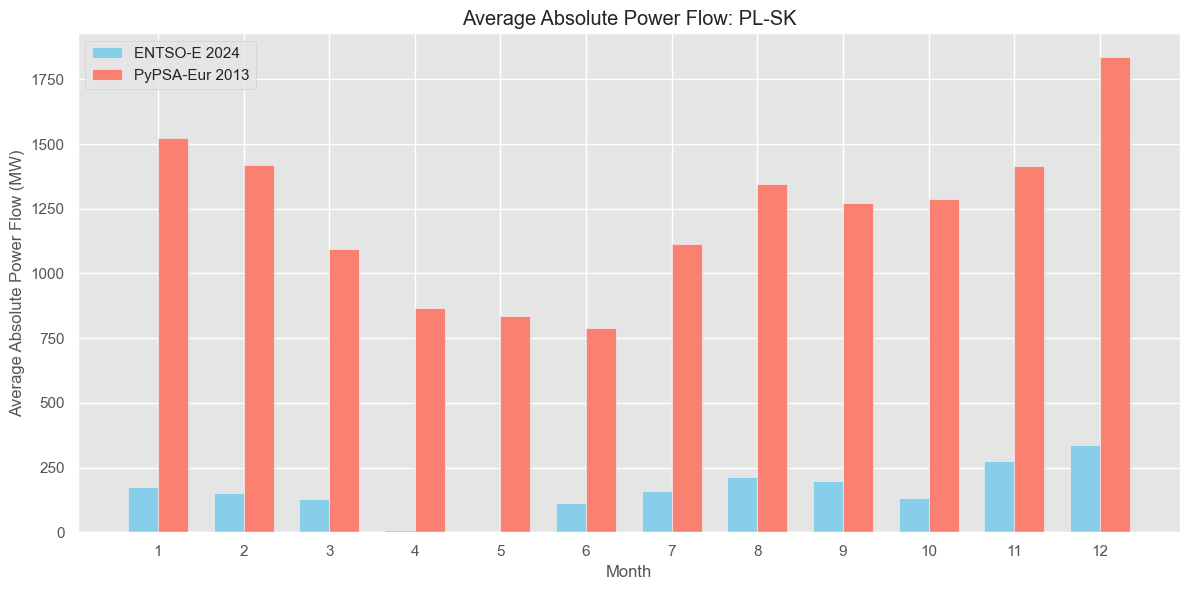

Average net export for PL: 3020.90 MW
Average net export for IT: -6936.57 MW
Average net export for NL: -204.49 MW
Average net export for DE: 7201.06 MW
Average net export for CZ: 249.25 MW
Average net export for GR: -264.06 MW


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set Matplotlib style
plt.style.use('ggplot')

# Dynamically generate line_connections from n.lines
line_connections = [(str(idx), row['bus0'], row['bus1']) for idx, row in n.lines.iterrows()]

# Connection mapping
connection_map = {line: f"{bus0[:2]}-{bus1[:2]}" for line, bus0, bus1 in line_connections}

# Step 1: Process ENTSO-E 2024 dataset
flows_2024 = pd.read_csv("physical_energy_power_flows_2024.csv", sep=';')
focus_countries = {'DE', 'NL', 'IT', 'PL', 'CZ', 'GR'}
flows_2024_monthly = flows_2024[flows_2024['MeasureTime'] == 'Monthly Value']
flows_2024_focus = flows_2024_monthly[
    flows_2024_monthly['FromAreaCode'].isin(focus_countries) | 
    flows_2024_monthly['ToAreaCode'].isin(focus_countries)
]

# Compute average absolute flows
avg_flows_2024 = flows_2024_focus.groupby(['FromAreaCode', 'ToAreaCode', 'Month'])['Value'].apply(
    lambda x: np.mean(np.abs(x))
).reset_index(name='Avg_Abs_Flow_2024_MW')
avg_flows_2024['Connection'] = avg_flows_2024.apply(
    lambda row: f"{row['FromAreaCode']}-{row['ToAreaCode']}", axis=1
)

# Step 2: Extract power flows for focus lines from PyPSA-Eur
def get_country(bus):
    return bus[:2] if len(bus) >= 2 else None

focus_lines = [
    line for line in n.lines.index
    if get_country(n.lines.loc[line, 'bus0']) in focus_countries
    or get_country(n.lines.loc[line, 'bus1']) in focus_countries
]
assert set(focus_lines).issubset(set(n.lines_t.p0.columns)), "Some focus_lines are not in n.lines_t.p0.columns"

power_flows_focus = n.lines_t.p0[focus_lines].reset_index().melt(
    id_vars='snapshot', var_name='line', value_name='p0'
)
power_flows_focus['Connection'] = power_flows_focus['line'].map(connection_map)
power_flows_focus['Month'] = power_flows_focus['snapshot'].dt.month
power_flows_focus['abs_p0'] = np.abs(power_flows_focus['p0'])

# Aggregate to monthly averages
monthly_flows_pypsa = power_flows_focus.groupby(['Connection', 'Month'])['abs_p0'].mean().reset_index(
    name='Avg_Abs_Flow_PyPSA_MW'
)

# Step 3: Compare ENTSO-E and PyPSA-Eur with bar plots
comparison_df = pd.merge(
    avg_flows_2024[['Connection', 'Month', 'Avg_Abs_Flow_2024_MW']],
    monthly_flows_pypsa,
    on=['Connection', 'Month'],
    how='inner'
)

# Plot bar graphs for each connection
for connection in comparison_df['Connection'].unique():
    conn_data = comparison_df[comparison_df['Connection'] == connection]
    months = conn_data['Month']
    flow_2024 = conn_data['Avg_Abs_Flow_2024_MW']
    flow_pypsa = conn_data['Avg_Abs_Flow_PyPSA_MW']

    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    x = np.arange(len(months))
    plt.bar(x - bar_width/2, flow_2024, bar_width, label='ENTSO-E 2024', color='skyblue')
    plt.bar(x + bar_width/2, flow_pypsa, bar_width, label='PyPSA-Eur 2013', color='salmon')
    plt.xlabel('Month')
    plt.ylabel('Average Absolute Power Flow (MW)')
    plt.title(f'Average Absolute Power Flow: {connection}')
    plt.xticks(x, months)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Step 4: Calculate net export for each focus country
def get_net_export(n, country, snapshots):
    net_export = pd.Series(0.0, index=snapshots)
    for line in n.lines.index:
        bus0_country = get_country(n.lines.loc[line, 'bus0'])
        bus1_country = get_country(n.lines.loc[line, 'bus1'])
        if bus0_country == country and bus1_country != country:
            net_export += n.lines_t.p0[line]
        elif bus1_country == country and bus0_country != country:
            net_export += -n.lines_t.p0[line]
    return net_export

for country in focus_countries:
    try:
        net_export = get_net_export(n, country, n.snapshots)
        avg_net_export = net_export.mean()
        print(f'Average net export for {country}: {avg_net_export:.2f} MW')
    except (KeyError, ValueError) as e:
        print(f"Error calculating net export for {country}: {e}")